<a href="https://colab.research.google.com/github/xubitt/car-racing-sac/blob/main/%5BCar%20Racing%5D%20Soft%20Actor-Critic%20(SAC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft Actor-Critic (SAC)

In [2]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00


In [3]:
!pip install stable_baselines3 gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 34.3 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376475 sha256=78b9f14a34786a6bdc52368203b06965dac2ee81b994b0f0b276df64a8cb1546
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [4]:
import gymnasium
import stable_baselines3
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.atari_wrappers import WarpFrame

import os
import numpy
import platform
import matplotlib
import matplotlib.pyplot
import torch
from importlib.metadata import version

In [5]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.10.12
Torch Version: 2.5.1+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 1.0.0
Numpy Version: 1.26.4
Scipy Version: 1.13.1
Swig Version: 4.3.0
Stable Baselines3 Version: 2.4.0
IPython Version: 7.34.0


In [7]:
env = gymnasium.make('CarRacing-v3')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


Observation Space Size:  (96, 96, 3)
Action Space Size:  (3,)


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [8]:
env_str = "CarRacing-v3"
log_dir = "./logs/{}".format(env_str)
gray_scale = True

# If gray_scale True, convert obs to gray scale 84 x 84 image
wrapper_class = WarpFrame if gray_scale else None

In [9]:
# Create Training CarRacing environment
env = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Create Evaluation CarRacing environment
env_val = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25,
                             render=False,
                             n_eval_episodes=20)

# Initialize SAC
# buffer_size - determines how big the replay buffer is
model = SAC('CnnPolicy', env, verbose=0, buffer_size=150)

# Train the model
model.learn(total_timesteps=750,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "sac_car_racing"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=25, episode_reward=-21.49 +/- 15.18

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=50, episode_reward=-23.96 +/- 11.95

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=75, episode_reward=-27.67 +/- 11.01

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=100, episode_reward=-20.98 +/- 12.86

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=125, episode_reward=-26.82 +/- 9.53

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150, episode_reward=-19.89 +/- 14.92

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=175, episode_reward=-23.08 +/- 15.29

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=200, episode_reward=-22.28 +/- 15.47

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=225, episode_reward=-21.65 +/- 16.78

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=250, episode_reward=-17.01 +/- 17.31

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=275, episode_reward=-18.08 +/- 17.42

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=300, episode_reward=-29.13 +/- 10.09

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=325, episode_reward=-18.29 +/- 16.35

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=350, episode_reward=-23.25 +/- 12.93

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=375, episode_reward=-17.31 +/- 21.26

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=400, episode_reward=-11.58 +/- 17.45

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=425, episode_reward=-18.56 +/- 15.69

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=450, episode_reward=-20.56 +/- 15.66

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=475, episode_reward=-16.11 +/- 19.42

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=500, episode_reward=-16.81 +/- 15.90

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=525, episode_reward=-15.60 +/- 17.85

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=550, episode_reward=-15.41 +/- 20.54

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=575, episode_reward=-26.77 +/- 13.07

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=600, episode_reward=-22.99 +/- 14.61

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=625, episode_reward=-21.11 +/- 16.94

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=650, episode_reward=-17.45 +/- 19.68

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=675, episode_reward=-19.37 +/- 18.64

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=700, episode_reward=-22.77 +/- 15.31

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=725, episode_reward=-24.43 +/- 14.82

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=750, episode_reward=-22.19 +/- 15.44

Episode length: 1000.00 +/- 0.00

Mean reward: -14.27 +/- 22.96


In [10]:
# Create Evaluation CarRacing environment
env = make_vec_env(env_str, n_envs=1, seed=0, wrapper_class=WarpFrame)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = SAC.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/",
                       video_length=100,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_car_racing_sac")

obs = env.reset()
for _ in range(100):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: -21.32 +/- 14.47
Saving video to /content/videos/best_model_car_racing_sac-step-0-to-step-100.mp4


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/best_model_car_racing_sac-step-0-to-step-100.mp4.
Moviepy - Writing video /content/videos/best_model_car_racing_sac-step-0-to-step-100.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_car_racing_sac-step-0-to-step-100.mp4


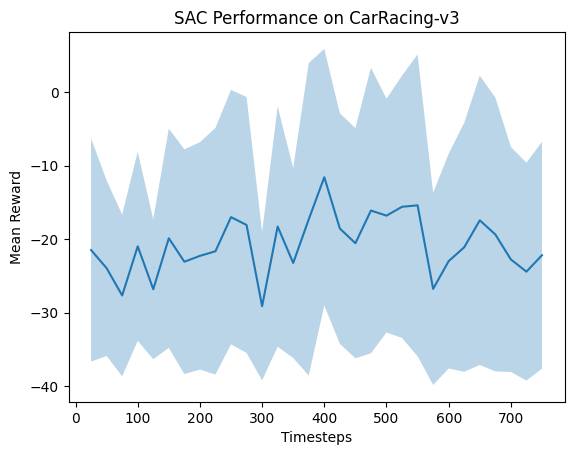

In [11]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel("Timesteps")
matplotlib.pyplot.ylabel("Mean Reward")
matplotlib.pyplot.title(f"SAC Performance on {env_str}")
matplotlib.pyplot.show()